In [19]:
%pylab inline --no-import-all
import numpy
import sklearn.mixture
import pickle
from PIL import Image, ImageDraw
import animator
import IPython.display
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_params(path):
    '''Plots the parameters of a given sequence'''
    titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $', '$ \\theta_{pv}$', 'product', 'ratio']
    matplotlib.pyplot.figure()
    matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
    for i in range(path.shape[1]):
        axes = matplotlib.pyplot.subplot(int(path.shape[1]/2),2,i+1)
        matplotlib.pyplot.plot(path[:,i])
        if i < path.shape[1]-1:
            matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
        matplotlib.pyplot.ylabel(titles[i])

In [3]:
def draw_polygon(polygons, size=(640, 480), outlines=['red', 'green', 'blue']):
    '''Draws polygons over an image'''
    image = Image.new('RGBA', size)
    draw = ImageDraw.ImageDraw(image)
    for id, polygon in enumerate(polygons):
        draw.polygon(polygon, outline=outlines[id])
        for i in range(len(polygon)/2):
            draw.text(polygon[2*i:2*i+2], str(i), fill=outlines[id])
    return image

In [4]:
def box_video(output, boxData):
    '''Generates a video drawing the specified polygons'''
    sequence = (draw_polygon([boxes[i] for boxes in boxData]) for i in numpy.arange(len(predictedPointsList)))
    animator.frames2video(sequence, 30, output)
    videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
    videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
    return videoTag.format(videoSrc)

In [5]:
#Load file with dictionary of each sequence trajectory parameters
trajFile = open('trajectoryParams.pkl', 'r')
trajectories = pickle.load(trajFile)
trajFile.close()

In [6]:
print 'Keys for {} sequences: {}'.format(len(trajectories.keys()), trajectories.keys())

Keys for 25 sequences: ['skating', 'bicycle', 'drunk', 'sphere', 'ball', 'gymnastics', 'hand1', 'hand2', 'diving', 'fish2', 'fish1', 'basketball', 'sunshade', 'polarbear', 'woman', 'bolt', 'surfing', 'tunnel', 'car', 'torus', 'fernando', 'david', 'jogging', 'trellis', 'motocross']


In [45]:
#Parameters of sample trajectories and accumulator
LENGTH = 60
N_FEATURES = 4
OFFSET = 1
seqDir = '/home/fmpaezri/datasets/vot-challenge/sequences/'
samples = numpy.empty((LENGTH, N_FEATURES))
print samples.shape

(60, 4)


In [47]:
#Trajectory subsampling and original trajectory plots
totalLength = 0
for aSequence in trajectories.keys():
    trajectory = trajectories[aSequence]
    seqSize = Image.open(os.path.join(seqDir, aSequence, '00000001.jpg')).size
    totalLength += trajectory.shape[0]
    print '{} length and dimensions: {}\t{}'.format(aSequence, trajectory.shape, seqSize)
    #plot_params(trajectory)
    for start in numpy.arange(0, trajectory.shape[0]-LENGTH, OFFSET):
        sample = trajectories[aSequence][start:start+LENGTH,:N_FEATURES]/numpy.array([seqSize[0], seqSize[1], 1, 1])
        sample = numpy.vstack([numpy.zeros((1, N_FEATURES)), numpy.diff(sample, axis=0)])
        samples = numpy.dstack([samples, sample])
samples = samples[:,:,1:]
print 'Total length: {}'.format(totalLength)

skating length and dimensions: (400, 8)	(640, 360)
bicycle length and dimensions: (271, 8)	(320, 240)
drunk length and dimensions: (1210, 8)	(508, 336)
sphere length and dimensions: (201, 8)	(480, 360)
ball length and dimensions: (603, 8)	(320, 240)
gymnastics length and dimensions: (207, 8)	(320, 180)
hand1 length and dimensions: (244, 8)	(320, 240)
hand2 length and dimensions: (267, 8)	(320, 240)
diving length and dimensions: (219, 8)	(400, 224)
fish2 length and dimensions: (310, 8)	(640, 360)
fish1 length and dimensions: (436, 8)	(460, 259)
basketball length and dimensions: (725, 8)	(576, 432)
sunshade length and dimensions: (172, 8)	(352, 288)
polarbear length and dimensions: (371, 8)	(640, 360)
woman length and dimensions: (597, 8)	(352, 288)
bolt length and dimensions: (350, 8)	(640, 360)
surfing length and dimensions: (282, 8)	(320, 240)
tunnel length and dimensions: (731, 8)	(360, 480)
car length and dimensions: (252, 8)	(640, 272)
torus length and dimensions: (264, 8)	(320, 24

(60, 4, 8714)
(8714, 240)
0.0


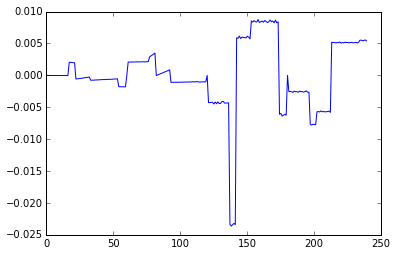

In [48]:
#Shape and reshape debugging 
print samples.shape
flatSample = samples.T.reshape(-1, LENGTH*N_FEATURES)
print flatSample.shape
print (flatSample[0,:].reshape(N_FEATURES, LENGTH).T-samples[0:LENGTH,:,0]).sum()
#matplotlib.pyplot.subplot(1,2,1)
matplotlib.pyplot.plot(flatSample[0,:])
#matplotlib.pyplot.subplot(1,2,2)
#matplotlib.pyplot.plot(samples[0:LENGTH,:,0].T.ravel())

In [49]:
#GMM training and sampling
MIXTURES = 256 # samples.shape[-1]/2
gmm = sklearn.mixture.GMM(n_components=MIXTURES, )
%time gmm.fit(flatSample)
%time predictedSamples = gmm.sample(n_samples=MIXTURES*5)

CPU times: user 1min 28s, sys: 76 ms, total: 1min 28s
Wall time: 1min 28s
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 38.6 ms


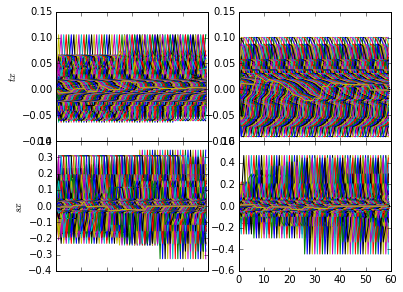

In [50]:
#Plot of samples
plot_params(samples.reshape(LENGTH, N_FEATURES, -1))

Sample index: 0


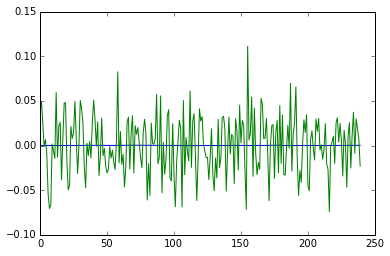

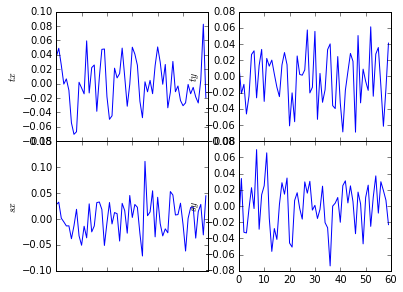

In [54]:
#Select a sample and plot boxes
sampleIndex = numpy.random.choice(predictedSamples.shape[0])
print 'Sample index: {}'.format(sampleIndex)
predictedSample = predictedSamples[sampleIndex,:].reshape(N_FEATURES, LENGTH).T
cluster = gmm.predict(predictedSample.T.ravel())[0]
matplotlib.pyplot.plot(gmm.means_[cluster])
matplotlib.pyplot.plot(predictedSample.T.ravel())
plot_params(predictedSample)
predictedPointsList = []
refPoints = numpy.array([[0,100,100,0],[0,0,100,100],[1,1,1,1]])
sceneSize = (640, 320)
#for tx, ty, sx, sy, theta, origTheta, product, ratio in predictedSample:
for tx, ty, sx, sy in predictedSample:
    theta = 0
    tx *= sceneSize[0]
    ty *= sceneSize[1]
    sx += 1.0
    sy += 1.0
    predictedTransform = numpy.array([[sx*numpy.cos(theta), sy*numpy.sin(theta), tx],[-sx*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
    predictedPoints = numpy.dot(predictedTransform, refPoints)
    predictedPointsList.append(predictedPoints[:2,:].T.flatten())
IPython.display.HTML(box_video('/tmp/video.mp4', [[point.tolist() for point in predictedPointsList]]))

(101,)


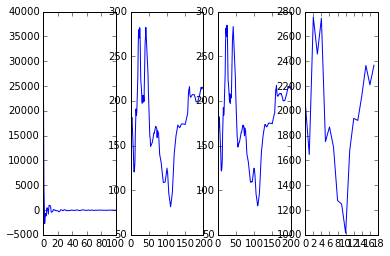

In [36]:
import numpy.fft
sampleKey = numpy.random.choice(trajectories.keys())
fft = numpy.fft.rfft(trajectories[sampleKey][:,0])
matplotlib.pyplot.subplot(1,4,1)
matplotlib.pyplot.plot(fft)
matplotlib.pyplot.subplot(1,4,2)
matplotlib.pyplot.plot(trajectories[sampleKey][:,0])
matplotlib.pyplot.subplot(1,4,3)
matplotlib.pyplot.plot(numpy.fft.irfft(fft))
matplotlib.pyplot.subplot(1,4,4)
matplotlib.pyplot.plot(numpy.fft.irfft(fft[:10]))
print fft.shape